In [4]:
# Install and import the necessary libraries
!pip install -q -U torch
!pip install -q -U accelerate peft bitsandbytes transformers trl einops evaluate
!pip install -q -U tqdm
!pip install -q -U scikit-dimension

In [5]:
import torch
from datasets import load_dataset
from datasets import load_from_disk
from transformers import (
    DistilBertModel,
    DistilBertTokenizer,
)
from tqdm import tqdm
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import numpy as np
import skdim
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import math

In [6]:
# Set device
torch.set_default_device("cuda")

# Load pre-trained model and tokenizer
model_name = "distilbert/distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name,
                                          add_eos_token=True,
                                          trust_remote_code=True)

tokenizer.pad_token = '[PAD]'
tokenizer.truncation_side = "right"

# Load dataset
dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset", split="train[:4500]")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/31232 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5205 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5206 [00:00<?, ? examples/s]

In [7]:
# Function that tokenizes the text
def tokenize(rows):
    # Retrieve Text
    if rows["text"][0] is None:
        text = ""
    else:
        text = rows["text"][0].replace('"', r'\"')

    # Tokenize
    encoded = tokenizer(
          text,
          add_special_tokens=True,
          max_length=260,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
          padding='max_length',
        ).to("cuda")


    return encoded

In [8]:
# Applying tokenization to the dataset
tokenized_dataset = dataset.map(tokenize,
                                batched=True,
                                batch_size=1,
                                remove_columns=["id", "text", "label", "sentiment"])

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [9]:
model = DistilBertModel.from_pretrained(model_name, device_map="cuda")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [10]:
# Persistent Homology Dimension
def compute_persistent_score(embeddings):
    """
    Compute the persistent score for a subset of embeddings using the sum of edge weights in the MST.
    
    Parameters:
    - embeddings (numpy.ndarray): A matrix where each row is an embedding.
    
    Returns:
    - float: The persistent score for the embeddings.
    """
    dist_matrix = distance_matrix(embeddings, embeddings)
    mst = minimum_spanning_tree(dist_matrix)
    return mst.sum()

In [11]:
def sample_and_score(embeddings, n, k=8, hat_n=40, J=7):
    """
    For various sample sizes, compute the median persistent score across J samples.
    
    Parameters:
    - embeddings (numpy.ndarray): A matrix where each row is an embedding.
    - n (int): Total number of embeddings.
    - k (int): Number of different sample sizes.
    - hat_n (int): A parameter for determining sample sizes.
    - J (int): Number of samples for each sample size.
    
    Returns:
    - list: List of sample sizes.
    - list: List of corresponding median persistent scores.
    """
    scores = []
    sizes = [(i - 1) * (n - hat_n) // k + hat_n for i in range(1, k + 1)]
    
    for size in sizes:
        subset_scores = [compute_persistent_score(embeddings[np.random.choice(n, size, replace=False)])
                         for _ in range(J)]
        scores.append(np.median(subset_scores))
    
    return sizes, scores

In [12]:
def estimate_dimension(sizes, scores):
    """
    Estimate the intrinsic dimension of the data using linear regression on log-transformed sizes and scores.
    
    Parameters:
    - sizes (list): List of sample sizes.
    - scores (list): List of corresponding median persistent scores.
    
    Returns:
    - float: Estimated dimension of the data.
    """
    log_sizes = np.log(sizes).reshape(-1, 1)
    log_scores = np.log(scores)

    reg = LinearRegression().fit(log_sizes, log_scores)
    slope = reg.coef_[0]
    
    return 1 / (1 - slope)

In [13]:
def estimate_sequence_dimension(embeddings, runs=5):
    """
    Estimate the intrinsic dimension of the text by repeatedly sampling subsets of its tokens, 
    computing their persistent scores, and then using linear regression on the log-transformed values.
    
    Parameters:
    - text (str): The input text for which the dimension needs to be estimated.
    - runs (int): Number of runs with different random seeds.
    
    Returns:
    - float: Estimated dimension of the text.
    """
    n = embeddings.shape[0]
    
    slopes = []
    for _ in range(runs):
        sizes, scores = sample_and_score(embeddings, n)
        log_sizes = np.log(sizes).reshape(-1, 1)
        log_scores = np.log(scores)
        
        reg = LinearRegression().fit(log_sizes, log_scores)
        slopes.append(reg.coef_[0])
    
    kappa_F = np.mean(slopes)
    return 1 / (1 - kappa_F)

In [14]:
methods = {
    "TwoNN": skdim.id.TwoNN(),
    "Maximum Likelihood": skdim.id.MLE(), 
    "Correlation Dimension": skdim.id.CorrInt(),
    "Tight Local ID": skdim.id.TLE(),
    "Persistent Homology": lambda embeddings: estimate_sequence_dimension(embeddings),
}

In [26]:
# Constants
torch.cuda.empty_cache()
gc.collect()
num_data = 2000
per_batch = 50
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

        # Perform forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        hidden_layers.append(liste)
        del outputs, liste, inputs
        torch.cuda.empty_cache()
        gc.collect()

# Move back to CPU
torch.set_default_device("cpu")

# Process hidden layers
hidden_layers_avg = []
n = len(hidden_layers[0])
for j in range(n):
    avg_batch_layer = []
    for i in range(number_batches * per_batch):
        layer = hidden_layers[i][j].detach().cpu()
        avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
    hidden_layers_avg.append(avg_batch_layer)

# Handle empty tensors
for layer in hidden_layers_avg:
    for idx, tensor in enumerate(layer):
        if tensor.shape == torch.Size([]):
            print("Encountered empty tensor. Filling with zeros.")
            layer[idx] = torch.zeros(2560)

# Stack hidden layers
hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
hidden_layers_stacked = torch.stack(hidden_layers_stacked)

del hidden_layers, hidden_layers_avg
gc.collect()

100%|██████████| 40/40 [07:54<00:00, 11.87s/it]


0

In [16]:
import time

In [27]:
intrinsic_dims = {method: [] for method in methods}
computation_times = {method: [] for method in methods}
for i in range(n):
    X = hidden_layers_stacked[i].numpy()

    # Compute the intrinsic dimension for each method
    for name, ide in methods.items():
        start_time = time.time()
        if name == "Persistent Homology":
            id_value = ide(X)  
        else:
            id_value = ide.fit_transform(X)
        end_time = time.time()
        intrinsic_dims[name].append(id_value)
        computation_times[name].append(end_time - start_time)

In [28]:
for name, times in computation_times.items():
    print(f"Computation time for {name}: {np.mean(times):.3f} s on average")

Computation time for TwoNN: 0.143 s on average
Computation time for Maximum Likelihood: 0.175 s on average
Computation time for Correlation Dimension: 0.204 s on average
Computation time for Tight Local ID: 1.163 s on average
Computation time for Persistent Homology: 808.166 s on average


In [29]:
# Matrix Entropy calculation
def normalize(R):
    with torch.no_grad():
        mean = R.mean(dim=0)
        R = R - mean
        norms = torch.norm(R, p=2, dim=1, keepdim=True)
        R = R/norms
    return R

def cal_cov(R):
    with torch.no_grad():
        Z = torch.nn.functional.normalize(R, dim=1)
        A = torch.matmul(Z.T, Z)/Z.shape[0]
    return A

def cal_entropy(A):
    with torch.no_grad():
        eig_val = torch.svd(A / torch.trace(A))[1] 
        entropy = - (eig_val * torch.log(eig_val)).nansum().item()
        normalized_entropy = entropy/math.log(A.shape[0])
    return normalized_entropy

In [30]:
entropy_list = []
for i in tqdm(range(0, 7)):
    X = hidden_layers_stacked[i]
    R = normalize(X)
    A = cal_cov(R)
    Entropy = cal_entropy(A)
    entropy_list.append(Entropy)

100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


In [31]:
intrinsic_dims

{'TwoNN': [30.780029697636152,
  24.470409942405876,
  25.983765605521665,
  25.917602735255056,
  28.87574759707033,
  29.474494031339773,
  27.7637558377515],
 'Maximum Likelihood': [28.88313912946572,
  23.500107099697875,
  22.203176726804806,
  22.518520144457,
  26.5600684034148,
  27.76313698414663,
  26.62118140318399],
 'Correlation Dimension': [3.648042205431125,
  12.723543516264654,
  13.269398053553665,
  12.936329783852761,
  14.293313217436264,
  13.758821264880378,
  12.94662367517308],
 'Tight Local ID': [23.987366595204062,
  20.248500122963385,
  19.88273011627777,
  20.13717537452495,
  23.333837278761376,
  23.825816500120478,
  22.533968129406436],
 'Persistent Homology': [18.745454564124035,
  22.614354305245453,
  21.03932751709619,
  20.699949428758483,
  26.093506653019084,
  25.645178778805683,
  26.911167305388165]}

In [32]:
entropy_list

[0.4283301287080222,
 0.6211566111312273,
 0.5785583604316062,
 0.596915628940272,
 0.6660779734518729,
 0.7045750364275511,
 0.7077300556980843]

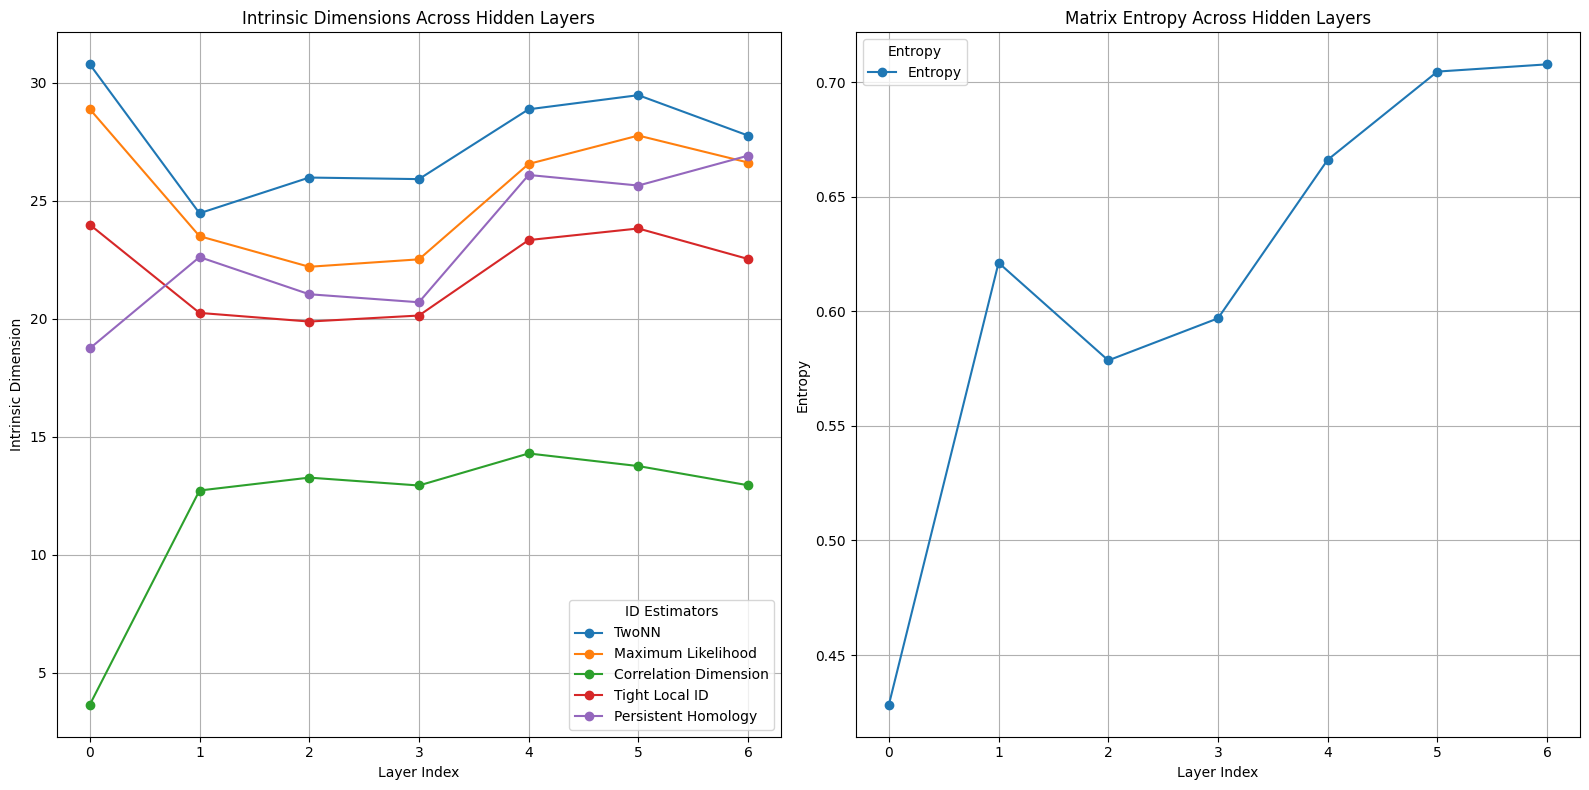

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot intrinsic dimensions
for name, id_values in intrinsic_dims.items():
    axes[0].plot(range(n), id_values, label=name, marker='o')

axes[0].set_xlabel('Layer Index')
axes[0].set_ylabel('Intrinsic Dimension')
axes[0].set_title('Intrinsic Dimensions Across Hidden Layers')
axes[0].legend(title="ID Estimators")
axes[0].grid(True)

axes[1].plot(range(n), entropy_list, label='Entropy', marker='o')
axes[1].set_xlabel('Layer Index')
axes[1].set_ylabel('Entropy')
axes[1].set_title('Matrix Entropy Across Hidden Layers')
axes[1].legend(title="Entropy")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [35]:
# Normality test to check if the variables (entropy and ID) are gaussian 
# Shapiro-Wilk Test
from scipy.stats import shapiro

alpha = 0.5

for name, id_values in intrinsic_dims.items():
    stat, p = shapiro(id_values)
    print(f'{name}: Statistics=%.3f, p=%.3f' % (stat, p))
    
    # interpret
    if p > alpha:
        print(f'Sample {name} looks Gaussian (fail to reject H0)')
    else:
         print(f'Sample {name} does not look Gaussian (reject H0)')
stat, p = shapiro(entropy_list)    
print(f'Matrix Entropy: Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print(f'Sample Matrix entropy looks Gaussian (fail to reject H0)')
else:
     print(f'Sample Matrix entropy does not look Gaussian (reject H0)')

TwoNN: Statistics=0.962, p=0.834
Sample TwoNN looks Gaussian (fail to reject H0)
Maximum Likelihood: Statistics=0.898, p=0.321
Sample Maximum Likelihood does not look Gaussian (reject H0)
Correlation Dimension: Statistics=0.597, p=0.000
Sample Correlation Dimension does not look Gaussian (reject H0)
Tight Local ID: Statistics=0.830, p=0.079
Sample Tight Local ID does not look Gaussian (reject H0)
Persistent Homology: Statistics=0.919, p=0.459
Sample Persistent Homology does not look Gaussian (reject H0)
Matrix Entropy: Statistics=0.884, p=0.245
Sample Matrix entropy does not look Gaussian (reject H0)


In [38]:
# Calculate Pearson's correlation - for gaussian distributed data
from scipy.stats import pearsonr, kendalltau, spearmanr
for title, id_values in intrinsic_dims.items():
    corr, _ = pearsonr(entropy_list, id_values)
    print(f"Pearson's correlation for {title}: {corr:.3f}")

Pearson's correlation for TwoNN: -0.211
Pearson's correlation for Maximum Likelihood: -0.071
Pearson's correlation for Correlation Dimension: 0.871
Pearson's correlation for Tight Local ID: 0.010
Pearson's correlation for Persistent Homology: 0.915


In [45]:
# Calculate Pearson's correlation - for gaussian distributed data
for title, id_values in intrinsic_dims.items():
    corr, _ = pearsonr(entropy_list[1:], id_values[1:])
    print(f"Pearson's correlation for {title}: {corr:.3f}")

Pearson's correlation for TwoNN: 0.775
Pearson's correlation for Maximum Likelihood: 0.968
Pearson's correlation for Correlation Dimension: 0.360
Pearson's correlation for Tight Local ID: 0.908
Pearson's correlation for Persistent Homology: 0.952


In [39]:
# calculate kendall's rank correlation - for non gaussian distributed data
for title, id_values in intrinsic_dims.items():
    corr, p = kendalltau(entropy_list, id_values)
    print(f"Pearson's correlation for {title}: {corr:.3f}")

Pearson's correlation for TwoNN: -0.048
Pearson's correlation for Maximum Likelihood: 0.333
Pearson's correlation for Correlation Dimension: 0.333
Pearson's correlation for Tight Local ID: 0.238
Pearson's correlation for Persistent Homology: 0.810


In [44]:
# calculate kendall's rank correlation - for non gaussian distributed data
for title, id_values in intrinsic_dims.items():
    corr, p = kendalltau(entropy_list[1:], id_values[1:])
    print(f"Pearson's correlation for {title}: {corr:.3f}")

Pearson's correlation for TwoNN: 0.333
Pearson's correlation for Maximum Likelihood: 0.867
Pearson's correlation for Correlation Dimension: 0.067
Pearson's correlation for Tight Local ID: 0.733
Pearson's correlation for Persistent Homology: 0.733


In [42]:
# calculate Spearman’s Rank Correlation - for non gaussian distributed data
for title, id_values in intrinsic_dims.items():
    corr, p = spearmanr(entropy_list, id_values)
    print(f"Pearson's correlation for {title}: {corr:.3f}")

Pearson's correlation for TwoNN: 0.000
Pearson's correlation for Maximum Likelihood: 0.214
Pearson's correlation for Correlation Dimension: 0.536
Pearson's correlation for Tight Local ID: 0.143
Pearson's correlation for Persistent Homology: 0.929


In [43]:
# calculate Spearman’s Rank Correlation - for non gaussian distributed data
for title, id_values in intrinsic_dims.items():
    corr, p = spearmanr(entropy_list[1:], id_values[1:])
    print(f"Pearson's correlation for {title}: {corr:.3f}")

Pearson's correlation for TwoNN: 0.600
Pearson's correlation for Maximum Likelihood: 0.943
Pearson's correlation for Correlation Dimension: 0.257
Pearson's correlation for Tight Local ID: 0.829
Pearson's correlation for Persistent Homology: 0.886


In [46]:
# exponential entropy analysis
expo = np.exp(entropy_list)
expo

array([1.53469264, 1.86107934, 1.78346546, 1.81650737, 1.94658776,
       2.02298681, 2.02937945])

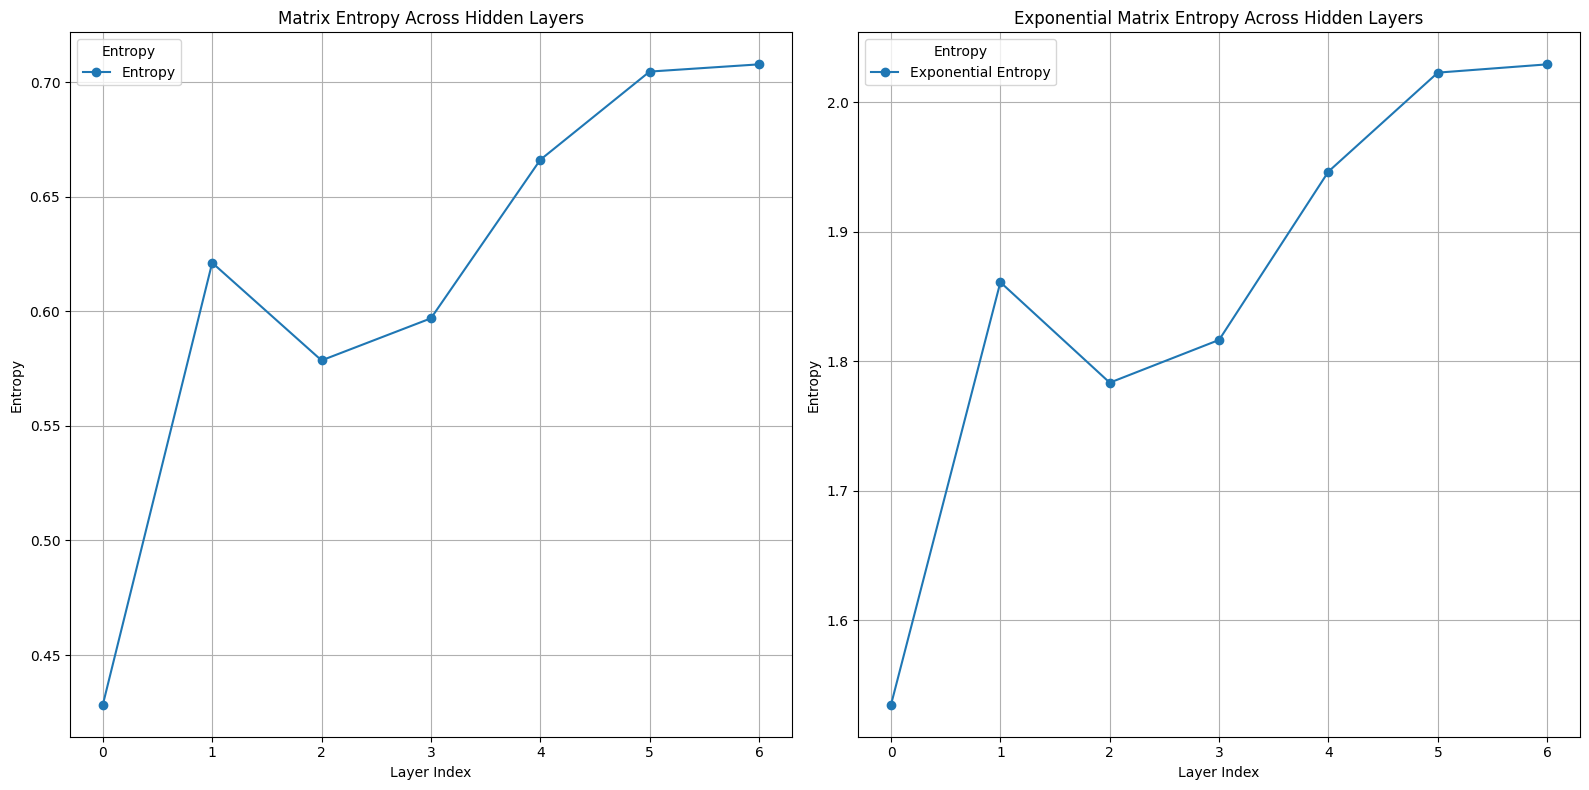

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].plot(range(n), entropy_list, label='Entropy', marker='o')
axes[0].set_xlabel('Layer Index')
axes[0].set_ylabel('Entropy')
axes[0].set_title('Matrix Entropy Across Hidden Layers')
axes[0].legend(title="Entropy")
axes[0].grid(True)

axes[1].plot(range(n), expo, label='Exponential Entropy', marker='o')
axes[1].set_xlabel('Layer Index')
axes[1].set_ylabel('Entropy')
axes[1].set_title('Exponential Matrix Entropy Across Hidden Layers')
axes[1].legend(title="Entropy")
axes[1].grid(True)

plt.tight_layout()
plt.show()